## 8.1
Find one tagging error in each of the following sentences that are tagged with the Penn Treebank tagset:
1. I/PRP need/VBP a/DT flight/NN from/IN Atlanta/NN
1. Does/VBZ this/DT flight/NN serve/VB dinner/NNS
1. I/PRP have/VB a/DT friend/NN living/VBG in/IN Denver/NNP
1. Can/VBP you/PRP list/VB the/DT nonstop/JJ afternoon/NN flights/NNS

In [1]:
import pandas as pd

pd.DataFrame([
    ['Attlanta/NN', 'Atlanta/NNP'],
    ['dinner/NNS', 'dinner/NN'],
    ['have/VB', 'have/VBP'],
    ['Can/VBP', 'Can/MD']
], columns=['error', 'answer'], index=list(range(1, 5)))

,error,answer
1,Attlanta/NN,Atlanta/NNP
2,dinner/NNS,dinner/NN
3,have/VB,have/VBP
4,Can/VBP,Can/MD


## 8.2
Use the Penn Treebank tagset to tag each word in the following sentences from Damon Runyon’s short stories. You may ignore punctuation. Some of these are quite difficult; do your best.
1. It is a nice night.
1. This crap game is over a garage in Fifty-second Street. . .
1. . . . Nobody ever takes the newspapers she sells . . .
1. He is a tall, skinny guy with a long, sad, mean-looking kisser, and a mournful voice.
1. . . . I am sitting in Mindy’s restaurant putting on the gefillte fish, which is a dish I am very fond of, . . .
1. When a guy and a doll get to taking peeks back and forth at each other, why there you are indeed.

1. It/PRP is/VBZ a/DT nice/JJ night/NN
1. This/DT crap/NNP game/NNP is/VBZ over/IN a/DT garage/NN in/IN FIfty-second/NNP Street/NNP
1. Nobody/NN ever/RB takes/VBZ the/DT newspapers/NNS she/PRP sells/VBZ
1. He/PRP is/VBZ a/DT tall/JJ skinny/JJ guy/NN with/IN a/DT long/JJ sad/JJ mean-looking/JJ kisser/NN and/CC a/DT mournful/JJ voice/NN
1. I/PRP am/VBP sitting/VBG in/IN Mindy/NNP 's/POS restaurant/NN putting/VBG on/IN the/DT gefillte/NNP fish/NNP which/WDT is/VBZ a/DT dish/NN I/PRP am/VBP very/RB fond/JJ of/IN
1. When/WRB a/DT guy/NN and/CC a/DT doll/NN get/VBP to/TO taking/VBG peeks/NNS back/RB and/CC forth/RB at/IN each/DT other/JJ why/WRB there/RB you/PRP are/VBP indeed/RB

## 8.3
Now compare your tags from the previous exercise with one or two friend’s answers. On which words did you disagree the most? Why?

## 8.4
Implement the “most likely tag” baseline. Find a POS-tagged training set, and use it to compute for each word the tag that maximizes $p(t|w)$. You will need to implement a simple tokenizer to deal with sentence boundaries. Start by assuming that all unknown words are NN and compute your error rate on known and unknown words. Now write at least five rules to do a better job of tagging unknown words, and show the difference in error rates.

In [2]:
# Download train.txt and test.txt from https://www.clips.uantwerpen.be/conll2000/chunking/
train_path = 'train.txt'
test_path = 'test.txt'

In [3]:
# Check its content.
with open(test_path) as f:
    for line in f.readlines()[30:46]:
        print(line.strip())

said VBD B-VP
the DT B-NP
agreement NN I-NP
calls VBZ B-VP
for IN B-SBAR
it PRP B-NP
to TO B-VP
supply VB I-VP
200 CD B-NP
additional JJ I-NP
so-called JJ I-NP
shipsets NNS I-NP
for IN B-PP
the DT B-NP
planes NNS I-NP
. . O


In [4]:
# See what kind of POS tags it has.
pos_set = set()

def add_pos(path):
    with open(path) as f:
        for line in iter(f.readline, ''):
            line = line.strip()
            if line:
                word, pos, bio = line.split(' ')
                pos_set.add(pos)

add_pos(train_path)
add_pos(test_path)

sorted(list(pos_set))

['#',
 '$',
 "''",
 '(',
 ')',
 ',',
 '.',
 ':',
 'CC',
 'CD',
 'DT',
 'EX',
 'FW',
 'IN',
 'JJ',
 'JJR',
 'JJS',
 'MD',
 'NN',
 'NNP',
 'NNPS',
 'NNS',
 'PDT',
 'POS',
 'PRP',
 'PRP$',
 'RB',
 'RBR',
 'RBS',
 'RP',
 'SYM',
 'TO',
 'UH',
 'VB',
 'VBD',
 'VBG',
 'VBN',
 'VBP',
 'VBZ',
 'WDT',
 'WP',
 'WP$',
 'WRB',
 '``']

In [5]:
# Load train and text dataset.
def load(path):
    pos_oov = {'#', '$', "''", '(', ')', ',', '.', ':', '``'}
    ds = {'words_list': [], 'pos_tags_list': []}
    with open(path) as f:
        for sent in f.read().strip().split('\n\n'):
            d = {'words': [], 'pos_tags': []}
            for line in sent.split('\n'):
                word, pos, bio = line.split(' ')
                if pos not in pos_oov:
                    d['words'].append(word.lower())
                    d['pos_tags'].append(pos)
            if d['words'] and d['pos_tags']:
                ds['words_list'].append(d['words'])
                ds['pos_tags_list'].append(d['pos_tags'])
    return ds

train = load(train_path)
test = load(test_path)

(again)  
Implement the “most likely tag” baseline. Find a POS-tagged training set, and use it to compute for each word the tag that maximizes $p(t|w)$. You will need to implement a simple tokenizer to deal with sentence boundaries. Start by assuming that all unknown words are NN and compute your error rate on known and unknown words. Now write at least five rules to do a better job of tagging unknown words, and show the difference in error rates.

In [6]:
# Implement "most likely tag"ger with assigning NN to unknown words
from collections import defaultdict, Counter
from typing import List

class MostLikelyTagger:
    def __init__(self):
        self.trained = False

    def __call__(self, X: List[List[str]]):
        if not self.trained:
            raise Error('Call fit method before predicting.')

        y = []
        for words in X:
            tags = []
            for word in words:
                if word not in self.d.keys():
                    tags.append(self._tag_by_rules(word))
                else:
                    tags.append(self.d[word])
            y.append(tags)
        return y

    def fit(self, X: List[List[str]], y: List[List[str]]):
        d = defaultdict(list)
        for words, tags in zip(X, y):
            for word, tag in zip(words, tags):
                d[word].append(tag)
        self.d = {word: Counter(tags).most_common()[0][0] for word, tags in d.items()}
        self.trained = True

    @staticmethod
    def _tag_by_rules(word):
        return 'NN'

def evaluate(preds: List[List[str]], labels: List[List[str]]) -> float:
    results = []
    for pred_tags, tags in zip(preds, labels):
        for pred_tag, tag in zip(pred_tags, tags):
            results.append(pred_tag == tag)

    return sum(results) / len(results)

In [7]:
# Check its accuracy word-wise
base_tagger = MostLikelyTagger()
base_tagger.fit(train['words_list'], train['pos_tags_list'])

base_preds = base_tagger(test['words_list'])

acc = evaluate(base_preds, test['pos_tags_list'])
print(f'accuracy: {acc}')

accuracy: 0.8741162891357669


In [8]:
# Next implement 5 rules for unknown words
import re

class ModifiedMostLikelyTagger(MostLikelyTagger):
    @staticmethod
    def _tag_by_rules(word):
        # Contains number -> CD
        if re.search('\d', word):
            return 'CD'
        # Ends with ing -> VBG
        elif word.endswith('ing'):
            return 'VBG'
        # Ends with ly -> RB
        elif word.endswith('ly'):
            return 'RB'
        # Ends with some adjective endings -> JJ
        elif re.search('\w+(able|alful|ic|ish|ive|less)$', word):
            return 'JJ'
        # Otherwise
        else:
            return 'NN'

In [9]:
# See how well the slightly rule-based model works
rule_tagger = ModifiedMostLikelyTagger()
rule_tagger.fit(train['words_list'], train['pos_tags_list'])

rule_preds = rule_tagger(test['words_list'])

acc = evaluate(rule_preds, test['pos_tags_list'])
print(f'accuracy: {acc}')

accuracy: 0.8843841677487616


## 8.5
Build a bigram HMM tagger. You will need a part-of-speech-tagged corpus. First split the corpus into a training set and test set. From the labeled training set, train the transition and observation probabilities of the HMM tagger directly on the hand-tagged data. Then implement the Viterbi algorithm so you can decode a test sentence. Now run your algorithm on the test set. Report its error rate and compare its performance to the most frequent tag baseline.

In [10]:
import itertools
from collections import Counter
from typing import List
import numpy as np
from tqdm.notebook import tqdm

class HMMTagger:
    def __init__(self):
        self.trained = False

    def __call__(self, X: List[List[str]]):
        if not self.trained:
            raise Error('Call fit method before predicting.')

        y = []
        for words in tqdm(X):
            tags = self.viterbi(words)
            y.append(tags)

        return y

    def viterbi(self, words: List[str]):
        viterbi = np.zeros((len(self.tags) - 1, len(words)))
        backpointer = np.zeros((len(self.tags) - 1, len(words)))
        vocab_set = set(self.vocab)

        init_word = words[0]
        for s in range(len(self.tags) - 1):
            if init_word in vocab_set:
                emission = self.emission_matrix[s, self.vocab.index(init_word)]
            else:
                emission = self.unknown_dist[s]
            viterbi[s, 0] = self.transition_matrix[self.tags.index('<s>'), s] * emission

        for t, word in enumerate(words[1:], 1):
            for s in range(len(self.tags) - 1):
                if word in vocab_set:
                    emission = self.emission_matrix[s, self.vocab.index(word)]
                    candidates = [viterbi[s_, t - 1] * self.transition_matrix[s_, s] * emission
                                  for s_ in range(len(self.tags) - 1)]
                else:
                    emission = self.unknown_dist[s]
                    candidates = [viterbi[s_, t-1] * emission for s_ in range(len(self.tags) - 1)]

                viterbi[s, t] = max(candidates)
                backpointer[s, t] = candidates.index(viterbi[s, t])

        pointer = viterbi[:, -1].argmax()
        length = len(words)
        tags = []
        for i in range(length):
            tag = self.tags[pointer]
            tags.append(tag)
            pointer = int(backpointer[:, length-i-1][pointer])

        return tags[::-1]

    def fit(self, X: List[List[str]], y: List[List[str]]):
        self.vocab = list(set(itertools.chain.from_iterable(X)))
        self.tags = list(set(itertools.chain.from_iterable(y)))
        self.tags.append('<s>')

        self.emission_matrix = np.zeros((len(self.tags) - 1, len(self.vocab)))
        self.transition_matrix = np.zeros((len(self.tags), len(self.tags) - 1))

        for words, tags in tqdm(zip(X, y), total=len(X)):
            for i in range(len(words)):
                self.emission_matrix[self.tags.index(tags[i]), self.vocab.index(words[i])] += 1
                if i < len(words) - 1:
                    self.transition_matrix[self.tags.index('<s>' if i == 0 else tags[i - 1]), self.tags.index(tags[i])] += 1

        # Extract tags of words which appear only once.
        # This will be used as a distribution for unknown words.
        tags = [self.tags[np.where(self.emission_matrix[:, i] == 1)[0][0]]
                for i in np.where(self.emission_matrix.sum(axis=0) == 1)[0]]
        count = Counter(tags)
        self.unknown_dist = np.array([0 if tag not in count.keys() else count[tag]
                                      for tag in self.tags if tag != '<s>'], dtype=np.float64)

        # add-k smoothing -> normalize
        k = 0.1
        self.emission_matrix += k
        self.emission_matrix /= self.emission_matrix.sum(axis=1).reshape(-1, 1)
        self.transition_matrix += k
        self.transition_matrix /= self.transition_matrix.sum(axis=1).reshape(-1, 1)
        self.unknown_dist += k
        self.unknown_dist /= self.unknown_dist.sum()

        self.trained = True

In [11]:
hmm_tagger = HMMTagger()
hmm_tagger.fit(train['words_list'], train['pos_tags_list'])

hmm_preds = hmm_tagger(test['words_list'])

acc = evaluate(hmm_preds, test['pos_tags_list'])
print(f'accuracy: {acc}')

  0%|          | 0/8936 [00:00<?, ?it/s]

  0%|          | 0/2012 [00:00<?, ?it/s]

accuracy: 0.9110758428317222


In [12]:
# But it takes around 0.1-0.2 seconds for one sentence...

## 8.6
Do an error analysis of your tagger. Build a confusion matrix and investigate the most frequent errors. Propose some features for improving the performance of your tagger on these errors.

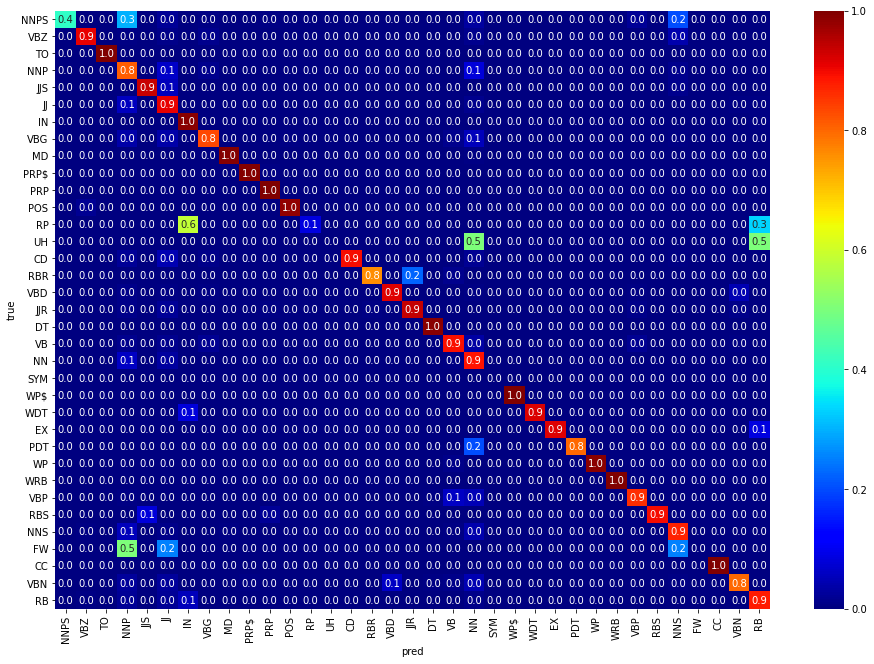

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline

tags = hmm_tagger.tags[:-1]

cm = confusion_matrix(
    list(itertools.chain.from_iterable(test['pos_tags_list'])),
    list(itertools.chain.from_iterable(hmm_preds)),
    labels = tags,
    normalize='true')

plt.figure(figsize=(16, 11))
sns.heatmap(cm, annot=True, fmt='1.1f', cmap='jet', xticklabels=tags, yticklabels=tags)
plt.xlabel('pred')
plt.ylabel('true')
plt.show()

## 8.7
Develop a set of regular expressions to recognize the character shape features described on page 17.

$
1\{x_{i} = the,\ y_{i} = DET\} \\
1\{y_{i} = PROPN,\ x_{i}+1 = Street,\ y_{i}−1 = NUM\} \\
1\{y_{i} = VERB,\ y_{i}−1 = AUX\}
$

## 8.8
The BIO and other labeling schemes given in this chapter aren’t the only possible one. For example, the $B$ tag can be reserved only for those situations where an ambiguity exists between adjacent entities. Propose a new set of $BIO$ tags for use with your NER system. Experiment with it and compare its performance with the schemes presented in this chapter.

## 8.9
Names of works of art (books, movies, video games, etc.) are quite different from the kinds of named entities we’ve discussed in this chapter. Collect a list of names of works of art from a particular category from a Web-based source (e.g., gutenberg.org, amazon.com, imdb.com, etc.). Analyze your list and give examples of ways that the names in it are likely to be problematic for the techniques described in this chapter.

## 8.10
Develop an NER system specific to the category of names that you collected in the last exercise. Evaluate your system on a collection of text likely to contain instances of these named entities.